Task: train on round 0 + 1, test on round 2  
Model: the same as the model we used to design round 2  
Questions to answer: 
- does the design conforms to what we expected?
    - are the sequences with top predicted mean have high TIR scores as well? Rank matters. 
    - For the sequences with high uncertainty, how does the exploration go? Can we open up/rollout new areas?
    - what part of the results turn out to be surprising and why? Can we learn something to design a better round in the next step?



In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/rec_design/round3_design
['/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/rec_design/round3_design', '/home/admin-u6015325/anaconda3/lib/python37.zip', '/home/admin-u6015325/anaconda3/lib/python3.7', '/home/admin-u6015325/anaconda3/lib/python3.7/lib-dynload', '', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/strkernel-0.2-py3.7.egg', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/admin-u6015325/.ipython', '/home/admin-u6015325/ownCloud/git/SynbioML']


In [2]:
norm_method = 'mean'
log_flag = 'True'
Path = '../../../data/Results_Microplate_partialTrue_normTrue_' + norm_method+ '_roundRep_formatSeq_log' + log_flag + '.csv'

known_df = pd.read_csv(Path)
known_df.head()


,idx,RBS,Name,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,...,Round,Rep7,Rep8,Rep9,Unnamed: 19,Unnamed: 20,RBS6,Pred Mean,Pred Std,Pred UCB
0,648.0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,2.482263,2.555338,2.358414,3.102950,2.999178,2.316265,2.635735,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
1,4096.0,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.592779,1.694296,1.798210,1.850738,2.381356,1.996343,1.885620,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
2,4097.0,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.626302,0.774704,0.947196,0.418233,0.532036,0.733023,0.671916,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
3,4098.0,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.696364,1.917735,1.568130,1.600853,1.803056,1.260720,1.641143,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
4,4099.0,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.582321,2.118618,1.417531,2.014216,1.831391,2.186262,1.858390,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN


In [3]:
# read train and test df from known data

train_df = known_df[known_df['Round']!=2]
test_df = known_df[known_df['Round'] == 2]

In [4]:
# copy from the pipeline for recommending round 2 seq

rec_size = 90
l = 6
s = 1
beta = 1
alpha = 2
sigma_0 = 1
kernel_name = 'WD_Kernel_Shift'
embedding = 'label'
kernel_norm_flag = True
centering_flag = True
unit_norm_flag = True

In [5]:
# train on train_df and test on test_df

top_n = Top_n_ucb(train_df, kernel_name=kernel_name, l=l, s=s, sigma_0=sigma_0,
                 embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta, 
                 kernel_norm_flag=kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag=unit_norm_flag,
                 df_design= test_df)

/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_design['train_test'] = 'Test'


In [6]:
top_n.prediction()

# write prediction to df_design
# AVERAGE: true TIR; pred mean/std: predictions
df_design = top_n.df_design

X train shape:  (1589, 20)
X test shape:  (93, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg


/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.beta * self.df_design['pred std']
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.beta * self.df_design['pred std']


In [8]:
df_design

,RBS,RBS6,pred mean,pred std,ucb
idx,,,,,
1191.0,TTTAAGACAGGCTTATACAT,CAGGCT,1.057220,0.736804,1.794024
2663.0,TTTAAGAGGCGCTTATACAT,GGCGCT,1.127501,0.680469,1.807969
2983.0,TTTAAGAGTGGCTTATACAT,GTGGCT,0.970618,0.742100,1.712718
1186.0,TTTAAGACAGGAGTATACAT,CAGGAG,1.167537,0.605947,1.773484
2727.0,TTTAAGAGGGGCTTATACAT,GGGGCT,1.159121,0.640050,1.799171
...,...,...,...,...,...
2762.0,TTTAAGAGGTAGGTATACAT,GGTAGG,0.795484,0.572102,1.367587
1527.0,TTTAAGACCTTCTTATACAT,CCTTCT,0.550637,0.696039,1.246675
648.0,TTTAAGAAGGAGATATACAT,AGGAGA,1.042282,0.193745,1.236027


### Show prediction vs true labels for round 2

The following plot shows the prediction in terms of a classification view. 
We identify "high TIR" RBS as the one with label higher than 1.
We use the color to show the predicted std. 
Given that we only have a small amount of data and we are exploring the design space, we are unlikely to be able to predict the label in precise.
So instead of a "regression" type of evaluation, we are more care about the following:
- whether we are able to exploit the design space? We expect the high TIR sequences are predicted to be high. 
- whether we are able to learn the label in the area we have high confidence? We expect the RBS with low predicted std would have predicted mean close to true TIR. 

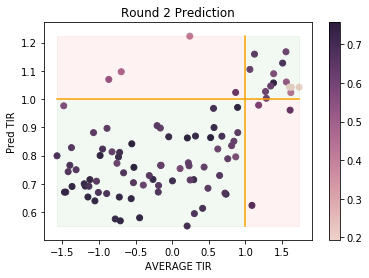

In [9]:
import seaborn as sns

threshold = 1.0
xlims = [test_df['AVERAGE'].min(), test_df['AVERAGE'].max()]
ylims = [df_design['pred mean'].min(), df_design['pred mean'].max()]

cmap = sns.cubehelix_palette(as_cmap=True)

plt.scatter(test_df['AVERAGE'], df_design['pred mean'], c = df_design['pred std'], cmap = cmap)
plt.fill_between([xlims[0], threshold], y1 = [threshold], y2= [ylims[-1]], color = 'r', alpha = 0.05)
plt.fill_between([threshold, xlims[1]], y1 = [ylims[0]], y2= [threshold], color = 'r', alpha = 0.05)
plt.fill_between([xlims[0], threshold], y1 = [ylims[0]], y2= [threshold], color = 'g', alpha = 0.05)
plt.fill_between([threshold, xlims[-1]], y1 = [threshold], y2= [ylims[1]], color = 'g', alpha = 0.05)
plt.colorbar()
plt.xlabel('AVERAGE TIR')
plt.ylabel('Pred TIR')
plt.title('Round 2 Prediction')
plt.plot(xlims, [threshold, threshold], color = 'orange')
plt.plot([threshold, threshold],ylims, color = 'orange')

The high and low TIR are classified correctly for most of the points (refer the red region for wrong classifcation).
Several observations:
- the points with pred std ~0.2 is the reference seq. It is predicted to be lower than the true label. 
- the predicted std seems to be very similar, most of them are 0.5-0.7.
- The three points in left upper region have low predicted std, but the prediction means are quite different from the true ones. 
Two very interesting examples there are:  

|RBS6  |AVERAGE|pred mean|pred std|
|------|-------|---------|--------|
|GGGGAG|0.24   |1.22     |0.41    |
|GGGGGG|1.62   |1.02     |0.43    |

clearly our predictor thinks GGGGAG and GGGGGG are similar, but the true label are quite different.
 

In [11]:
df_design.sort_values(['pred std'])[['RBS6', 'pred mean', 'pred std']]

,RBS6,pred mean,pred std
idx,,,
648.0,AGGAGA,1.042282,0.193745
648.0,AGGAGA,1.042282,0.193745
648.0,AGGAGA,1.042282,0.193745
2722.0,GGGGAG,1.222843,0.415742
2730.0,GGGGGG,1.022900,0.434026
...,...,...,...
2151.0,GACGCT,0.765504,0.748196
1255.0,CATGCT,0.863558,0.753841
4007.0,TTGGCT,0.841683,0.754074


Try to answer the questions asked at the beginning of this notebook

- are the sequences with top predicted mean have high TIR scores as well?  
*answer:* for the most of sequences, the classification bewteen high and low TIR are in high accuracy.
- For the sequences with high uncertainty, how does the exploration go? Can we open up/rollout new areas?  
*answer:* it hard to say from the above plot, worth combining observed with the tsne plot.
- what part of the results turn out to be surprising and why? Can we learn something to design a better round in the next step?  
*answer:* There are a few sequences with low predicted std but a very low prediction score (i.e. large difference between pred mean and AVERAGE).

#### check the wds distance between GGGGAG and GGGGGG


In [12]:

with open(config.SAVED_IDX_SEQ_PATH, 'rb') as handle:
    idx_seq = pickle.load(handle)

idx_seq_dict = idx_seq['idx_seq_dict']
# idx_seq_dict

In [36]:
idx_seq.keys()

dict_keys(['idx_seq_dict', 'idx_list', 'seq_list'])

In [13]:
pre_design = 'TTTAAGA'
pos_design = 'TATACAT'
idx1 = idx_seq_dict[pre_design + 'GGGGGG' + pos_design]
idx2 = idx_seq_dict[pre_design + 'GGGGAG' + pos_design]

In [14]:
from codes.kernels_for_GPK import *

wds_kernel = WD_Shift_Kernel(l = 6, s=1)

wd_shift_distance = wds_kernel.distance(wds_kernel.kernel_all_normalised)

wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...


In [15]:
# min/max among all design space
print('(global) min distance: ', wd_shift_distance.min(), ' max distance: ', wd_shift_distance.max())

# min/max among all train data 
distances_train_idx2 = wd_shift_distance[np.asarray(train_df['idx'].astype(int)),:][:,idx2]
print('distance to GGGGAG in train data, (local) min distance: ', distances_train_idx2.min(), ' max distance: ', distances_train_idx2.max())
print('closest seq to GGGGAG in train data: ', idx_seq_dict[np.asarray(train_df['idx'])[distances_train_idx2.argmin()]][7:13])

distances_train_idx1 = wd_shift_distance[np.asarray(train_df['idx'].astype(int)),:][:,idx1]
print('distance to GGGGGG in train data, (local) min distance: ', distances_train_idx1.min(), ' max distance: ', distances_train_idx1.max())
print('closest seq to GGGGGG in train data: ', idx_seq_dict[np.asarray(train_df['idx'])[distances_train_idx1.argmin()]][7:13])

print('wds distance between GGGGGG and GGGGAG is', wd_shift_distance[idx1, idx2])

(global) min distance:  0.0  max distance:  1.5438398706156513
distance to GGGGAG in train data, (local) min distance:  0.8583649641035263  max distance:  1.530138780853485
closest seq to GGGGAG in train data:  GGGGAT
distance to GGGGGG in train data, (local) min distance:  0.8198270153480833  max distance:  1.526783649048057
closest seq to GGGGGG in train data:  CGGGGG
wds distance between GGGGGG and GGGGAG is 0.8560361621129924


## WDS Distance v.s. Hamming distance 

In [16]:
from scipy.spatial.distance import hamming

In [17]:
if os.path.exists(config.SAVED_KERNEL_PATH):
    with open(config.SAVED_KERNEL_PATH, 'rb') as handle:
        SAVED_KERNELS = pickle.load(handle)
else:
    print('No saved kernel dictionary found. Create one...')
    SAVED_KERNELS = {} # key: kernel name (with parameters); value: kernel matrix
    
if 'hamming' in list(SAVED_KERNELS.keys()):
    print('Load saved kernel matrix...')
    hamming_distance = SAVED_KERNELS['hamming']  
else:
    all_seq = idx_seq['seq_list']

    hamming_distance = np.zeros((len(all_seq), len(all_seq)))

    for i, seq_i in enumerate(all_seq):
        for j, seq_j in enumerate(all_seq):
            if i < j:
                hamming_distance[i,j] = hamming(list(seq_i), list(seq_j))*len(list(seq_i))
    hamming_distance = hamming_distance + hamming_distance.T
    SAVED_KERNELS['hamming']   = hamming_distance

with open(config.SAVED_KERNEL_PATH, 'wb') as handle:
    pickle.dump(SAVED_KERNELS, handle, protocol=pickle.HIGHEST_PROTOCOL)
del SAVED_KERNELS
print('Kernel saved.')


Load saved kernel matrix...
Kernel saved.


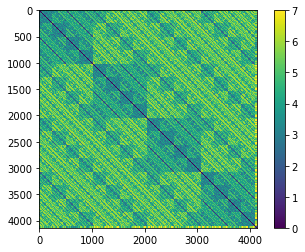

In [18]:
plt.imshow(hamming_distance)
plt.colorbar()

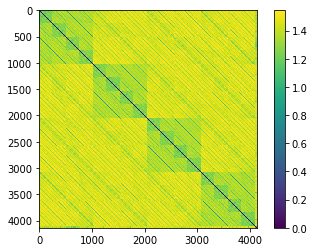

In [19]:
plt.imshow(wd_shift_distance)
plt.colorbar()

In [33]:
# distance_dict = {'wds': wd_shift_distance}

# with open('distance.pickle', 'wb') as handle:
#     pickle.dump(distance_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('distance.pickle', 'rb') as handle:
#     distance_dict = pickle.load(handle)
    
# distance_dict

In [20]:
# wds kernel with l = 2,3,4,5

wds_kernel_2_5 = WD_Shift_Kernel(l = 5, s=1, min_l = 2)

wd_shift_distance_2_5 = wds_kernel_2_5.distance(wds_kernel_2_5.kernel_all_normalised)

wds_l5_sigma0_1_s1_center_True_unitnorm_Trueminl_2
Load saved kernel matrix...


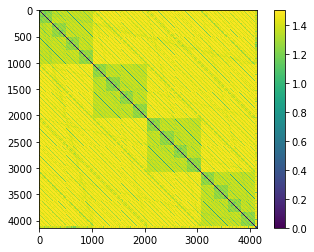

In [21]:
plt.imshow(wd_shift_distance_2_5)
plt.colorbar()

In [22]:
# min/max among all design space
print('(global) min distance: ', wd_shift_distance_2_5.min(), ' max distance: ', wd_shift_distance_2_5.max())

# min/max among all train data 
distances_2_5_train_idx2 = wd_shift_distance_2_5[np.asarray(train_df['idx'].astype(int)),:][:,idx2]
print('distance to GGGGAG in train data, (local) min distance: ', distances_2_5_train_idx2.min(), ' max distance: ', distances_2_5_train_idx2.max())
print('closest seq to GGGGAG in train data: ', idx_seq_dict[np.asarray(train_df['idx'])[distances_2_5_train_idx2.argmin()]][7:13])

distances_2_5_train_idx1 = wd_shift_distance_2_5[np.asarray(train_df['idx'].astype(int)),:][:,idx1]
print('distance to GGGGGG in train data, (local) min distance: ', distances_2_5_train_idx1.min(), ' max distance: ', distances_2_5_train_idx1.max())
print('closest seq to GGGGGG in train data: ', idx_seq_dict[np.asarray(train_df['idx'])[distances_2_5_train_idx1.argmin()]][7:13])

(global) min distance:  0.0  max distance:  1.5022652870048012
distance to GGGGAG in train data, (local) min distance:  0.8815412655085021  max distance:  1.4937305263050584
closest seq to GGGGAG in train data:  GGGGAT
distance to GGGGGG in train data, (local) min distance:  0.8416522558717968  max distance:  1.4895496419340142
closest seq to GGGGGG in train data:  CGGGGG


## Compare Hamming distance v.s. WDS distance 

take the upper triangle　of both the hamming and wds kernel distance matrix, and do scatter plot.  --- To many points.

Let's try another method: select those with hamming distance 1 in the upper triangle and record the corresponding wds distance. Plot the histogram of the recorded wds distance.

In [23]:
recorded_wds = []

for i in range(hamming_distance.shape[0]):
    for j in range(i, hamming_distance.shape[1]):
        assert j >= i
        if hamming_distance[i,j] == 1:
            recorded_wds.append(wd_shift_distance[i,j])

Text(0.5, 1.0, 'wds distance histogram according to hamming distance = 1')

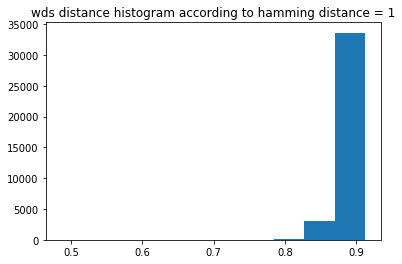

In [26]:
plt.hist(recorded_wds)
plt.title('wds distance histogram according to hamming distance = 1')

Text(0.5, 1.0, 'wds distance histogram')

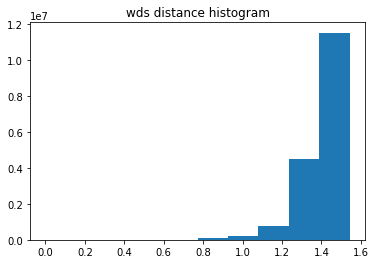

In [28]:
plt.hist(wd_shift_distance.flatten())
plt.title('wds distance histogram')

In [29]:
idx_seq_dict['TTTAAGAGGGGGCTATACAT']

2729